In [ ]:
#default_exp augmentations

# Augmentations

> Helper functions to make working with Albumentations and Fast.ai easier

In [ ]:
# export 

from fastai.vision.all import *
import albumentations as A
from icevision.all import *
from drone_detector.data import *

/home/mayrajeo/miniconda3/envs/dronedetector/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729047590/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## AlbumentationsTransform

In [ ]:
# export

class AlbumentationsTransform(RandTransform):
    "A transform handler for multiple `Albumentation` transforms in simple classification or regression tasks."
    split_idx, order = None, 2
    
    def __init__(self, train_aug, valid_aug=None): store_attr()
    
    def before_call(self, b, split_idx): self.idx = split_idx
        
    def encodes(self, img:PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            if self.valid_aug is not None: aug_img = self.valid_aug(image=np.array(img))['image']
            else: return img
        return PILImage.create(aug_img)
    
    def encodes(self, img:MultiChannelTensorImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img).transpose(1,2,0))['image'].transpose(2,0,1)
        else:
            if self.valid_aug is not None: aug_img = self.valid_aug(image=np.array(img).transpose(1,2,0))['image'].transpose(2,0,1)
            else: return img
        return MultiChannelTensorImage.create(aug_img)


## SegmentationAlbumentationsTransform

In [ ]:
# export

class SegmentationAlbumentationsTransform(ItemTransform):
    "A transform handler for `Albumentation` transforms for segmentation tasks."
    split_idx = 0
    
    def __init__(self, aug): store_attr()
        
    def encodes(self, x):
        "Because TypeDispatch doesn't work on tuple with specific types we need to do this"
        img, mask = x
        if isinstance(img, PILImage) and isinstance(mask, PILMask):
            aug = self.aug(image=np.array(img), mask=np.array(mask))
            return PILImage.create(aug['image']), PILMask.create(aug['mask'])
        
        elif isinstance(img, PILImage) and isinstance(mask, RegressionMask):
            aug = self.aug(image=np.array(img), mask=np.array(mask))
            return PILImage.create(aug['image']), RegressionMask.create(aug['mask'])
    
        elif isinstance(img, MultiChannelTensorImage) and isinstance(mask, PILMask):
            img = np.array(img).transpose(1, 2, 0)
            aug = self.aug(image=img, mask=np.array(mask))
            return (MultiChannelTensorImage.create(aug['image'].transpose(2,0,1)),
                    PILMask.create(aug['mask']))
                    
        elif isinstance(img, MultiChannelTensorImage) and isinstance(mask, RegressionMask):
            img = np.array(img).transpose(1,2,0)
            aug = self.aug(image=img, mask=np.array(mask))
            return (MultiChannelTensorImage.create(aug['image'].transpose(2,0,1)),
                    RegressionMask.create(aug['mask']))

        elif isinstance(img, MultiChannelTensorImageTuple) and isinstance(mask, PILMask):
            n_imgs = len(img)
            img = np.array(torch.cat(img)).transpose(1, 2, 0)
            aug = self.aug(image=img, mask=np.array(mask))
            return (MultiChannelTensorImageTuple.create(np.split(aug['image'].transpose(2,0,1), n_imgs)),
                    PILMask.create(aug['mask']))
                    
        elif isinstance(img, MultiChannelTensorImageTuple) and isinstance(mask, RegressionMask):
            n_imgs = len(img)
            img = np.array(torch.cat(img)).transpose(1, 2, 0)
            aug = self.aug(image=img, mask=np.array(mask))
            return (MultiChannelTensorImageTuple.create(np.split(aug['image'].transpose(2,0,1), n_imgs)),
                    RegressionMask.create(aug['mask']))
    
        else: return x

In [ ]:
path = Path('example_data/monthly_data')
month='july'

fnames = [path/f'{month}/{f}' for f in os.listdir(path/f'{month}') if f.endswith('.tif')][:2]

In [ ]:
transform_list = [A.ToFloat(max_value=10000.0, always_apply=True),
                  A.RandomBrightnessContrast(p=0.5,brightness_limit=.05, brightness_by_max=False),
                  A.RandomRotate90(p=1),
                  A.HorizontalFlip(p=.5),
                  A.VerticalFlip(p=.5),
                  A.CoarseDropout(),
                  A.FromFloat(max_value=10000.0, dtype=np.float32, always_apply=True)
                 ]

In [ ]:
used_tfms =  SegmentationAlbumentationsTransform(A.Compose(transform_list))

In [ ]:
segm = TifSegmentationDataLoaders.from_label_func(path/f'{month}_2018', fnames, y_block=RegressionMaskBlock,
                                                  label_func=partial(label_with_matching_fname, 
                                                                     path=path/'masks'),
                                                  batch_tfms = [
                                                      #Normalize.from_stats(*stats)
                                                  ],
                                                  item_tfms = [used_tfms], 
                                                  bs=1)

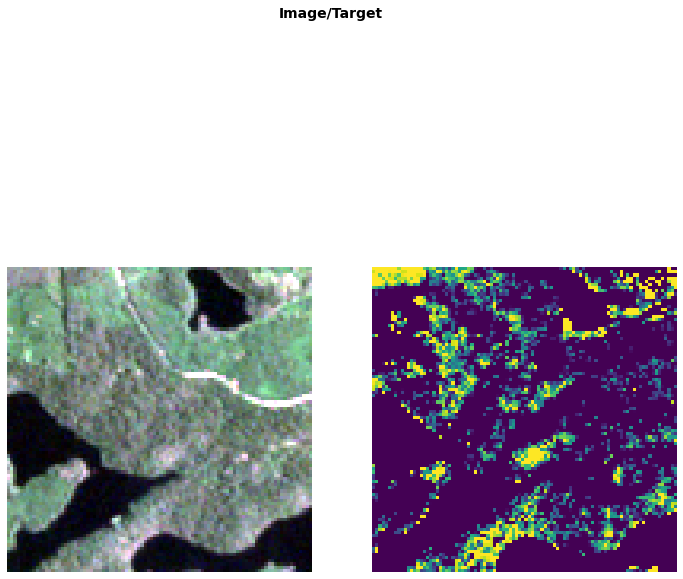

In [ ]:
segm.show_batch(channels=[3,2,1])

In [ ]:
files = get_image_timeseries(path, 
                             months=['may', 'june', 'july', 'august', 'september', 'october'], masks='masks')

In [ ]:
dblock = DataBlock(blocks=(MultiChannelImageTupleBlock, 
                           RegressionMaskBlock),
                   get_items=lambda x: x,
                   get_x=get_all_but_last, get_y=get_last,
                   item_tfms=[
                       used_tfms
                   ],
                   batch_tfms=[ 
                   ])

In [ ]:
dls = dblock.dataloaders(files[:1], bs=1)

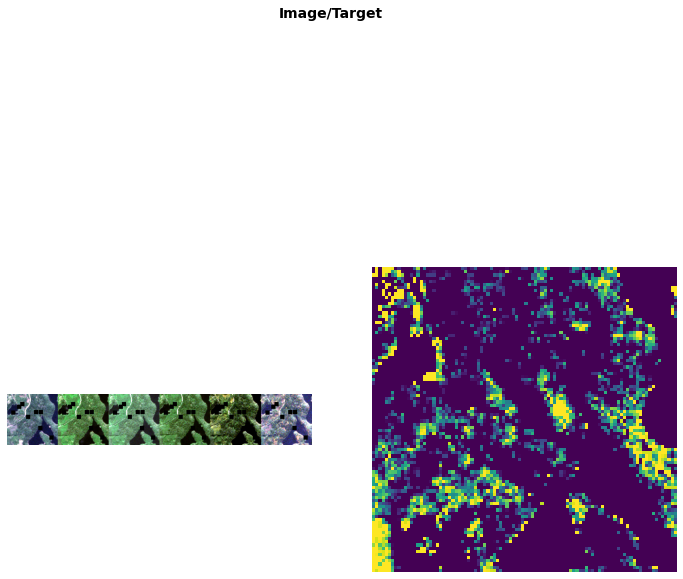

In [ ]:
dls.show_batch(channels=[3,2,1])

## Utils functions

In [ ]:
# export

def segmentation_aug_tfms_fastai(size=160):
    "Utilize `tfms.A.aug_tfms` with fastai and SegmentationDataloaders"
    return SegmentationAlbumentationsTransform(A.Compose(tfms.A.aug_tfms(size=size, crop_fn=tfms.A.RandomCrop)))
